## pyWAXS
#### Python-Based X-ray Scattering Data Reduction Notebook 
##### Toney Group, Updated: 10/24/2023, Demi's Notebook
------------

### Install pyWAXS Modules
Restart the Kernel after you do this.

In [1]:
# !python setup.py clean # uncomment if pip installation fails due to false path
%pip install -e /Users/keithwhite/github_repositories/pyWAXS # sub your pyWAXS/main directory here.

# import importlib.util
# spec = importlib.util.find_spec("pywaxs") # uncomment to check the pywaxs origin information
# print(spec)

# !pip list # uncomment to check your imports list for pywaxs

# import sys # uncomment to check system pathes accessed by your kernel
# print(sys.path)

Obtaining file:///Users/keithwhite/github_repositories/pyWAXS
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pywaxs
    Found existing installation: pywaxs 0.2.0
    Uninstalling pywaxs-0.2.0:
      Successfully uninstalled pywaxs-0.2.0
  Running setup.py develop for pywaxs
Note: you may need to restart the kernel to use updated packages.


### Class & Module Imports

In [1]:
'''
from WAXSTransform import WAXSTransform
from WAXSSearch import WAXSSearch
from WAXSReduce import WAXSReduce
from WAXSFileManager import WAXSFileManager as waxsfiles
'''

# - Custom Module Imports
from pywaxs import WAXSTransform
from pywaxs import WAXSSearch
from pywaxs import WAXSReduce
from pywaxs.WAXSReduce import Integration1D
from pywaxs import WAXSFileManager as waxsfiles
# from pywaxs import WAXSTOPAS

# - Additional Module Imports
import xarray as xr # type: ignore
import pandas as pd # type: ignore
import numpy as np
import pathlib, os # , copy2
from pathlib import Path
from typing import Optional
import matplotlib.pyplot as plt
import math

### Functions
- Create Data Folder Function
- Load Pandas Dataframe from Spreadsheet - Find Files

In [ ]:

def load_int_file(file_path: Path, wavelength: float) -> pd.DataFrame:
    # Read the file, skipping the first two lines
    df = pd.read_csv(file_path, skiprows=2, header=None, delimiter='\s+')
    
    # Rename the columns
    df.columns = ['twotheta', 'intensity', 'error']
    
    # Calculate q based on twotheta and wavelength
    df['q'] = (4 * math.pi / wavelength) * np.sin(np.radians(df['twotheta'] / 2))
    
    # Add headers for wavelength and file path
    df.attrs['wavelength'] = wavelength
    df.attrs['file_path'] = str(file_path)
    
    return df

def create_folder_structure(base_path: Path, folder_name: str):
    """
    Creates the main folder and its subfolders based on the provided base path and folder name.
    """
    main_folder = base_path.joinpath(folder_name)
    
    # Create main folder if it doesn't exist
    main_folder.mkdir(parents=True, exist_ok=True)
    
    # Define additional subfolders and subsubfolders
    subfolders = ['poni', 'mask', 'data', 'analysis', 'poscar', 'stitch']
    subsubfolders = ['hdf5', 'png', 'simulation']

    # Create subfolders
    for sub in subfolders:
        subfolder_path = main_folder.joinpath(sub)
        subfolder_path.mkdir(parents=True, exist_ok=True)
        
        # Create subsubfolders under 'analysis'
        if sub == 'analysis':
            for subsub in subsubfolders:
                subsubfolder_path = subfolder_path.joinpath(subsub)
                subsubfolder_path.mkdir(parents=True, exist_ok=True)

def create_project_folders(project_input: Union[str, Path], base_path: Path):
    """
    Generalizes the folder and subfolder creation process for multiple project names.
    Project names are either specified individually or extracted from an Excel file's 'Project Folder Name' column.
    """
    # Handle case where project_input is an Excel file
    if isinstance(project_input, Path):
        df = pd.read_excel(project_input)
        project_names = df['Project Folder Name'].unique()
    else:
        project_names = [project_input]
    
    # Create folder structure for each unique project name
    for project_name in project_names:
        create_folder_structure(base_path, project_name)

def populate_tiff_details_in_excel(excel_path: Path, tiff_folder_path: Path, output_csv_path: Path):
    """
    Reads an Excel file and populates the 'scanID', 'filename', and 'filepath' fields based on the .tiff files in a folder.
    
    Parameters:
    - excel_path: Path to the input Excel file
    - tiff_folder_path: Path to the folder containing the .tiff files
    - output_csv_path: Path to save the updated DataFrame as a CSV
    
    Returns:
    - DataFrame with updated fields
    """
    # Read Excel into DataFrame
    df = pd.read_excel(excel_path)
    
    # Initialize empty lists to hold the new values
    new_scanIDs = []
    new_filenames = []
    new_filepaths = []
    
    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        # Extract necessary values from each row
        filename_prefix = str(row['filename_prefix'])
        substrateID = str(row['substrateID'])
        position = str(row['position'])
        incidence_angle = str(row['incidence_angle'])
        exptime = str(row['exptime'])

        # Construct the search prefix
        search_prefix = f"{filename_prefix}{substrateID}_{position}_{incidence_angle}_{exptime}"
        # print (search_prefix)
        # Initialize variables to hold the new values for this row
        new_scanID = ''
        new_filename = ''
        new_filepath = ''
        
        # Loop through each .tiff file in the folder and check if it starts with the search prefix
        for tiff_file in tiff_folder_path.glob("*.tiff"):
            if tiff_file.name.startswith(search_prefix):
                # Extract details from the filename
                details = tiff_file.name[len(search_prefix):].split('_')
                new_scanID = details[1]
                new_filename = tiff_file.name
                new_filepath = str(tiff_file)
                break
        
        # Append the new values to the lists
        new_scanIDs.append(new_scanID)
        new_filenames.append(new_filename)
        new_filepaths.append(new_filepath)
        
    # Update the DataFrame with the new values
    df['scanID'] = new_scanIDs
    df['filename'] = new_filenames
    df['filepath'] = new_filepaths
    
    # Save the updated DataFrame as a CSV
    df.to_csv(output_csv_path, index=False)
    
    return df

def copy_tiff_files_to_project_folders(df: pd.DataFrame, base_path: Path):
    """
    Copies .tiff files to their respective project folders based on the DataFrame.
    
    Parameters:
    - df: DataFrame with the 'filepath' and 'projectname' fields
    - base_path: Base path where the project folders are located
    
    Returns:
    - None
    """
    for index, row in df.iterrows():
        src_filepath = Path(row['filepath'])
        project_folder_name = row['projectname']
        if src_filepath.exists():
            dest_folder = base_path.joinpath(project_folder_name, 'data')
            dest_folder.mkdir(parents=True, exist_ok=True)
            
            dest_filepath = dest_folder.joinpath(src_filepath.name)
            copy2(src_filepath, dest_filepath)

#### Input File Loader Paths

In [ ]:
excel_path = Path("/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/231012_demisamples.xlsx")
basePath = Path("/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects")
tiff_folder_path = Path("/Users/keithwhite/Desktop/activedata/KWhite4/waxs/raw")
output_csv_path = '/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/updated.csv'

# Run the function
updated_df = populate_tiff_details_in_excel(excel_path, tiff_folder_path, output_csv_path)
updated_df.head()

#### Copy Files to Project Folders

In [ ]:
# copy_tiff_files_to_project_folders(updated_df, basePath)

## Import Project

In [2]:
## -- CHANGE THE PROJECT NAME & ScanID -- ##
projectnames = ['002-D3_1-An-C2_DMF', '002-D4_1-An-C2_NMP', '002-D5_1-An-C2_6-1']
scanIDs =  ['682375', '682387', '682399'] # Replace with the scanID you want to use

i = 2 # select the sample
projectname = projectnames[i]
scanID = scanIDs[i]

# -- Base Path Definitions -- #
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects')
projectPath, PathList = waxsfiles.generate_projectPaths(basePath, projectname)
basePath, dataPath, poniPath, maskPath, analysisPath, poscarPath, hdf5Path, pngPath, simulationPath = PathList
dataPath = waxsfiles.update_filePath(dataPath, 'tiff', scanID=scanID)

# Print results
print(f"Project Path: {projectPath}")
print(f"Data Path: {dataPath}")
print(f"PONI Path: {poniPath}")
print(f"MASK Path: {maskPath}")

Multiple .tiff files found in the folder.
Project Path: /Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/002-D5_1-An-C2_6-1
Data Path: /Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/002-D5_1-An-C2_6-1/data/DD_002-D5_pos1_th0.250_15.00s_682399_waxs.tiff
PONI Path: /Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/002-D5_1-An-C2_6-1/poni/poni_pos1_DD_000-D0_AgBH_pos1_th0.120_5.00s_683860_waxs.poni
MASK Path: /Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/002-D5_1-An-C2_6-1/mask/mask_pos1_DD_000-D0_AgBH_pos1_th0.120_5.00s_683860_waxs.edf


#### Define Metadata Keylist

In [3]:
metadata_keylist = ['damaradayton', # Damara Dayton
                    'substrateID', # Substrate ID
                    'detector_position', # Detector Position
                    'incident_angle', # Incidence Angle
                    'exptime', # Exposure Time
                    'scanID', # Scan ID
                    'detext'] # Extension of the detector identifier at BNL 'maxs' v. 'saxs' v, 'waxs'

#### Create a WAXSReduce Project Instance Example

In [4]:
# - WAXSReduce Class Instantiation: Load the data, apply mask, calculate and map q-range, Ewald sphere corrections/pixel splitting, and caked pixel splitting.
waxs_analysis = WAXSReduce(poniPath=poniPath, 
        maskPath=maskPath, 
        tiffPath=dataPath, 
        metadata_keylist=metadata_keylist,
        energy = 12.7)

'''
# methods = 'np', 'cython', 'bbox', 'splitpix', 'lut'
# Run the 1D integration using the run_pg_integrate1D method.
# waxs_analysis.run_pg_integrate1D(npt=1024, 
#                                  method='bbox', # 
#                                  correctSolidAngle=True, 
#                                  polarization_factor=None)
'''

"\n# methods = 'np', 'cython', 'bbox', 'splitpix', 'lut'\n# Run the 1D integration using the run_pg_integrate1D method.\n# waxs_analysis.run_pg_integrate1D(npt=1024, \n#                                  method='bbox', # \n#                                  correctSolidAngle=True, \n#                                  polarization_factor=None)\n"

#### View the Reciprocal Space Map

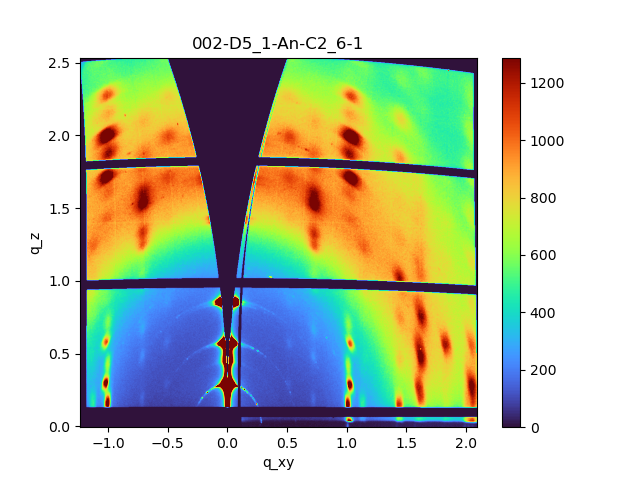

In [5]:
%matplotlib widget

data = waxs_analysis.reciptiff_xr

# Display Image
waxs_analysis.display_image(data, 
                            title=projectname, 
                            cmap='turbo')

# data = waxs_analysis.fold_image(data, 'chi')
# data, (max_x, max_y) = waxs_analysis.normalize_image(img = data, 
#                                                   normalizerecip=False)

#### Generate a .xye File for TOPAS

In [ ]:
# Create a WAXSTOPAS instance based on the existing WAXSReduce instance
# waxs_topas = WAXSTOPAS(projectPath=projectPath, waxs_instance=waxs_analysis)

# Now you can call the .xye generation method
# waxs_topas.generate_xye_file()

#### Load a .int pXRD Simulated File for Comparison

In [ ]:
intPath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/AgBh_Calib/poscar/agbh_cif.int')
wavelength = 0.9763 # Å^-1

# Load the data
loaded_data = load_int_file(intPath, wavelength)
loaded_data.head(), loaded_data.attrs

#### Plot the pXRD .int Simulation

In [ ]:
# Initialize the figure
%matplotlib widget

plt.figure(figsize=(6, 4))

# Boolean variable to toggle normalization
normalize_traces = True

qr_min = float(0.1)
qr_max = float(3)

filtered_data = loaded_data[(loaded_data['q'] >= qr_min) & (loaded_data['q'] <= qr_max)]

if normalize_traces:
    plt.plot(filtered_data['q'], filtered_data['intensity'] / filtered_data['intensity'].max(), label='Loaded .int File')
else:
    plt.plot(filtered_data['q'], filtered_data['intensity'], label='Loaded .int File')

plt.legend()
plt.xlabel('q / qr')
plt.ylabel('Intensity')
plt.title('1D Integrated Data Comparison')
plt.grid(True)
plt.show()

#### Plot the Data & pXRD Simulation Together

In [ ]:
# Initialize the figure
plt.figure(figsize=(6, 4))

# Boolean variable to toggle normalization
normalize_traces = True

# methods = ['lut', 'bbox']
methods = ['bbox']
for method in methods:
    waxs_analysis.run_pg_integrate1D(npt=2048, method=method, correctSolidAngle=True, polarization_factor=-0)
    intensity_values = waxs_analysis.integrate1d_da.values
    if normalize_traces:
        intensity_values /= intensity_values.max()
    plt.plot(waxs_analysis.integrate1d_da.qr, intensity_values, label=f'pygix {method}')

qr_min = float(waxs_analysis.integrate1d_da.qr.min())
qr_max = float(waxs_analysis.integrate1d_da.qr.max())
filtered_data = loaded_data[(loaded_data['q'] >= qr_min) & (loaded_data['q'] <= qr_max)]

if normalize_traces:
    plt.plot(filtered_data['q'], filtered_data['intensity'] / filtered_data['intensity'].max(), label='Loaded .int File')
else:
    plt.plot(filtered_data['q'], filtered_data['intensity'], label='Loaded .int File')

plt.legend()
plt.xlabel('q / qr')
plt.ylabel('Intensity')
plt.title('1D Integrated Data Comparison')
plt.grid(True)
plt.show()


### Generalized Analysis Flow

#### Image Processing

#### sin(chi) Correction

In [ ]:
# Caked Image Sin-Chi Correction: Apply sin(chi) correction to the caked image.
cakedtiff_sinchi_xr = waxs_analysis.sinchi_corr(chicorr = True, 
                                                qsqr = False)

# Image Normalization: Normalize the caked image.
cakedtiff_xr_norm, (max_x, max_y) = waxs_analysis.normalize_image(img = waxs_analysis.cakedtiff_sinchi_xr, 
                                                  normalizerecip=False)
data = cakedtiff_xr_norm

#### Image Folding

In [ ]:
# Image Folding: Fold the caked image.
folded_data = waxs_analysis.fold_image(data, 'chi')
data = folded_data

#### Interpolation

In [ ]:
data = waxs_analysis.cakedtiff_xr

# Image Normalization: Normalize the caked image.
data, (max_x, max_y) = waxs_analysis.normalize_image(img = data, 
                                                  normalizerecip=False)

# Image Interpolation: Interpolate the folded image.
# interpolator = ImageInterpolator() # Create the interpolator object. 
# data = interpolator.simple_interpolate(data, 'horizontal', 'slinear') # interpolate horizontal gaps with slinear method.
# data = interpolator.simple_interpolate(data, 'vertical', 'slinear') # interpolate unfilled vertical gaps with slinear method.

#### Plotting Output

In [ ]:
# Image Folding: Fold the caked image.
data = waxs_analysis.cakedtiff_xr
data = waxs_analysis.fold_image(data, 'chi')
data, (max_x, max_y) = waxs_analysis.normalize_image(img = data, 
                                                  normalizerecip=False)

# Display Image
waxs_analysis.display_image(data, 
                            title='folded', 
                            cmap='turbo')

In [ ]:
waxs_analysis.reciptiff_xr

## Peak Finding
Find the peaks using a our custom peak finding algorithm.

Parameters:
- sigma1 (float, default=1.0): The standard deviation for the first Gaussian filter.
- sigma2 (float, default=2.0): The standard deviation for the second Gaussian filter.
- threshold (float, default=0.2): Threshold for initial peak identification.
- clustering_method (str, default='DBSCAN'): The clustering method to use ('DBSCAN' or 'HDBSCAN').
- eps (float, default=3): The maximum distance between two samples for them to be considered as in the same cluster (DBSCAN).
- min_samples (int, default=2): The number of samples in a neighborhood for a point to be considered as a core point (DBSCAN).
- k (int, default=3): The number of nearest neighbors to consider for the recentering algorithm.
- radius (float, default=5): The radius within which to search for neighbors in the recentering algorithm.
- edge_percentage (float, default=5): The percentage of the minimum edge length to be considered as the edge zone.
- stricter_threshold (float, default=0.01): A stricter threshold for edge peaks.

In [ ]:
%matplotlib widget

'''
# data = waxs_analysis.reciptiff_xr
# data = waxs_analysis.fold_image(data, 'chi')
# data, (max_x, max_y) = waxs_analysis.normalize_image(img = data, 
#                                                   normalizerecip=False)
'''

data = waxs_analysis.reciptiff_xr

# Find peaks (implement the actual peak-finding logic in the find_peaks method)
peak_finder = WAXSSearch(data) # create the WAXSSearch object

# NOTE: Make sure you pass the ACTIVE DataArray you are working on, notice how I passed 'data' 
# since this is the processed dataset we are working with locally.

const_params = {
    'threshold': 0.005,
    'clustering_method': 'HDBSCAN',
    'eps': 3,
    'min_samples': 2,
    'k': 8,
    'radius': 4,
    'edge_percentage': 4,
    'stricter_threshold': 20
}

dataset = peak_finder.waxssearch_main(sigma1=.12,
                                        sigma2=2.5,
                                        **const_params)

# Display image with peaks
peak_finder.display_image_with_peaks_and_DoG(dataset,
                                       title='peak finder', 
                                       cmap='turbo')

peak_finder.save_to_netcdf(hdf5Path) # Creates an hdf5 file with the name 'output.nc' in your output path. Will generalize
# the file naming convention for this soon.

#### Peak Search Parameter Sensitivity Analysis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Import the WAXSSearch class and any other dependencies here

# Define constant parameters
const_params = {
    'threshold': 0.0005,
    'clustering_method': 'HDBSCAN',
    'eps': 3,
    'min_samples': 2,
    'k': 8,
    'radius': 4,
    'edge_percentage': 4,
    'stricter_threshold': 20
}
# Assume that 'data' is available here or load it

# Define ranges for sigma1 and sigma2
sigma1_values = np.linspace(0.1, 1.2, 20)
sigma2_values = np.linspace(1.3, 3, 20)

# Create a matrix to store the results
num_peaks_matrix = np.zeros((len(sigma1_values), len(sigma2_values)))

# Run the simulation
for i, sigma1 in enumerate(sigma1_values):
    for j, sigma2 in enumerate(sigma2_values):
        # Create a WAXSSearch object with the current 'data'
        peak_finder = WAXSSearch(data)
        
        # Run the actual waxssearch_main method
        dataset = peak_finder.waxssearch_main(sigma1=sigma1,
                                              sigma2=sigma2,
                                              **const_params)
        
        # Extract the number of peaks found
        num_peaks = np.count_nonzero(dataset['peak_positions'].values == 1)
        num_peaks_matrix[i, j] = num_peaks


# Convert to DataFrame for better annotation in heatmap
df_num_peaks = pd.DataFrame(num_peaks_matrix, index=np.round(sigma1_values, 2), columns=np.round(sigma2_values, 2))

plt.close('all')

# Generate the heatmap
sns.heatmap(df_num_peaks, annot=True, fmt=".0f", cmap="YlGnBu")
plt.xlabel("Sigma2 Values")
plt.ylabel("Sigma1 Values")
plt.title("Heatmap of Number of Peaks Detected")
plt.show()

In [ ]:
import imageio  # for creating GIF
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Define constant parameters
const_params = {
    'clustering_method': 'HDBSCAN',
    'eps': 1,
    'min_samples': 2,
    'k': 4,
    'radius': 2,
    'edge_percentage': 2,
    'stricter_threshold': 5
}

# Define ranges for sigma1, sigma2, and threshold
sigma1_values = np.linspace(0.1, 1.2, 20)
sigma2_values = np.linspace(1.3, 3, 20)
threshold_values = np.linspace(0.0001, 0.001, 10)  # Replace with your range

# Initialize a list to store heatmap frames
frames = []

# Loop over different threshold values
for t, threshold in enumerate(threshold_values):
    num_peaks_matrix = np.zeros((len(sigma1_values), len(sigma2_values)))

    for i, sigma1 in enumerate(sigma1_values):
        for j, sigma2 in enumerate(sigma2_values):
            if sigma1 >= sigma2:
                continue

            peak_finder = WAXSSearch(data)
            dataset = peak_finder.waxssearch_main(sigma1=sigma1, sigma2=sigma2, threshold=threshold, **const_params)
            num_peaks = np.count_nonzero(dataset['peak_positions'].values == 1)
            num_peaks_matrix[i, j] = num_peaks

    # Convert to DataFrame
    df_num_peaks = pd.DataFrame(num_peaks_matrix, index=np.round(sigma1_values, 2), columns=np.round(sigma2_values, 2))
    
    # Generate and save the heatmap
    plt.figure()
    sns.heatmap(df_num_peaks, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.xlabel("Sigma2 Values")
    plt.ylabel("Sigma1 Values")
    plt.title(f"Heatmap of Number of Peaks Detected (Threshold={threshold})")
    
    # Save as PNG
    plt.savefig(f"heatmap_{t}.png")
    
    # Append to frames for GIF
    frames.append(imageio.imread(f"heatmap_{t}.png"))

# Create GIF
imageio.mimsave('heatmap.gif', frames, duration=1)  # 1-second duration for each frame


In [ ]:
from IPython.display import display, Image

# Display GIF in Jupyter Notebook
with open('heatmap.gif','rb') as file:
    display(Image(file.read()))


## Load Existing Project File

In [ ]:
# waxsPath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/1MAI_3PbI2_DMF_1M_mar23/analysis/hdf5/3MAI_1PbI2_DMF_1M_mar23_peaks.nc')
waxsPath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/1MAI_3PbI2_DMF_1M_mar23/analysis/hdf5/output.nc')

waxs_ds = waxs_analysis.load_xarray_dataset(waxsPath)

waxs_ds.info()

In [ ]:
waxs_ds_peaks = WAXSSearch(waxs_ds) # create the WAXSSearch object

# Display image with peaks
waxs_ds_peaks.display_image_with_peaks(waxs_analysis.ds,
                                       title='manual peaks', 
                                       cmap='turbo')

### 1D Integration Methods

In [ ]:
integrator = Integration1D(waxs_analysis)

Now your integrator object 'integrator' has access to and references your active 'waxs_analysis' session. 

It also has access to all of the WAXSReduce() methods. You can prove it to yourself like this:

#### (1) Cake Slide 1D: Display 2D Caked Image

In [ ]:
integrator.display_image(integrator.cakedtiff_xr, # Display the caked data we will manipulate with the 1D image processing.
                            title='processed', 
                            cmap='turbo')

#### (1) Cake Slice 1D

In [ ]:
integrator = Integration1D(waxs_analysis)

integrator.cakeslice1D(integrator.cakedtiff_xr, chislice=[-90, 90], qrslice=[0, 4], cakeslicesum='chi')

integrator.display_image1D(integrator.cakeslice1D_xr, color='red')

#### (2) Boxcut 1D: Display 2D Recip Space Map

In [ ]:
%matplotlib widget
# integrator = Integration1D(waxs_analysis)
integrator.display_image(integrator.reciptiff_xr, # Display the caked data we will manipulate with the 1D image processing.
                            title='recip space map', 
                            cmap='turbo')

#### (2) Box Cut 1D

In [ ]:
# Updated `process_slices` function to dynamically generate a sample name prefix based on the slices
def process_slices(integrator, base_samplenameprefix, pngPath, plot_interpolated=False, interpolate_gaps = False, interp_method = 'linear', order = None):
    # Qz Layer Lines
    qxyslice_qz = [-2.5, 2.5]
    qzslice_qz_list = [
        [.42, .57],
        [.9, 1.07],
        [1.42, 1.58],
        [1.83, 2.16],
        [2.4, 2.6]
    ]
    
    for qzslice in qzslice_qz_list:
        dynamic_samplenameprefix = f"{base_samplenameprefix}_qxyrange{qxyslice_qz[0]}_{qxyslice_qz[1]}_qzrange{qzslice[0]}_{qzslice[1]}"
        title = generate_title('qz', qxyslice_qz, qzslice)
        integrator.boxcut1D(integrator.reciptiff_xr, qxyslice=qxyslice_qz, qzslice=qzslice, boxcutsum='qz', interpolate_gaps=interpolate_gaps, interp_method = interp_method, order = None)
        integrator.display_image1D(integrator, color='blue', title=title, save_image=True, samplenameprefix=dynamic_samplenameprefix, savePath=pngPath, plot_interpolated=plot_interpolated)
        
    # Qxy Layer Lines
    qzslice_qxy = [0, 3]
    qxyslice_qxy_list = [
        [-0.95, -0.7],
        [-1.18, -1.08],
        [-1.7, -1.45],
        [-2.06, -1.9],
        [-2.24, -2.1],
        [-2.36, -2.26]
    ]
    
    for qxyslice in qxyslice_qxy_list:
        dynamic_samplenameprefix = f"{base_samplenameprefix}_qxyrange{qxyslice[0]}_{qxyslice[1]}_qzrange{qzslice_qxy[0]}_{qzslice_qxy[1]}"
        title = generate_title('qxy', qxyslice, qzslice_qxy)
        integrator.boxcut1D(integrator.reciptiff_xr, qxyslice=qxyslice, qzslice=qzslice_qxy, boxcutsum='qxy', interpolate_gaps=interpolate_gaps, interp_method = interp_method)
        integrator.display_image1D(integrator, color='red', title=title, save_image=True, samplenameprefix=dynamic_samplenameprefix, savePath=pngPath, plot_interpolated=plot_interpolated)
        
# The generate_title function for reference
def generate_title(boxcutsum, qxyslice=None, qzslice=None):
    if boxcutsum == 'qz':
        title = f"Qz Layer Lines (Qxy: {qzslice[0]} to {qzslice[1]})"
    elif boxcutsum == 'qxy':
        title = f"Qxy Layer Lines (Qz: {qxyslice[0]} to {qxyslice[1]})"
    return title

In [ ]:
# base_samplenameprefix = '3MAI1PbI2_DMF_1M'
# # interp_method = 'cubic', 'slinear', 'nearest', 'zero', 'linear'
# interp_method = 'linear'
# process_slices(integrator, base_samplenameprefix, pngPath, plot_interpolated=False, interpolate_gaps = False, interp_method = 'linear', order = None)

#### (3) Pole Figure 1D: Display 2D Caked Image

In [ ]:
integrator.display_image(integrator.cakedtiff_xr, # Display the caked data we will manipulate with the 1D image processing.
                            title='processed', 
                            cmap='turbo')

#### (3) Pole Figure 1D

In [ ]:
# integrator.polefig1D(integrator.cakedtiff_xr, pole_chislice=[-90, 90], pole_qrslice=[1.8, 1.92], qrcenter=1.85, chicenter=0, poleleveler='linear')
integrator.polefig1D(integrator.cakedtiff_xr, pole_chislice=[-90, 90], pole_qrslice=[.62, .75], qrcenter=.67, chicenter=0, poleleveler='average')
# integrator.polefig1D(integrator.cakedtiff_xr, pole_chislice=[-90, 90], pole_qrslice=[.62, .75], qrcenter=.67, chicenter=0, poleleveler=None)
# integrator.polefig1D(integrator.cakedtiff_xr, pole_chislice=[-90, 90], pole_qrslice=[.62, .75], qrcenter=.67, chicenter=0, poleleveler='linear')

integrator.display_image1D(integrator.polefig1D_xr, color='blue')

#### (4) Azimuthal Integration: Display the 2D Recip Space Map
This is effectively the same as the caked integration, but with our own custom pixel splitting routine.

In [ ]:
integrator.display_image(integrator.reciptiff_xr, # Display the caked data we will manipulate with the 1D image processing.
                            title='recip space map', 
                            cmap='turbo')

##### (i) Raw Data

In [ ]:
%matplotlib widget
waxs_analysis.rawdisplay_xr()
# waxs_analysis.rawtiff_xr

##### (ii) Reciprocal Space Map

In [ ]:
%matplotlib widget
waxs_analysis.recipdisplay_xr()
# waxs_analysis.reciptiff_xr

##### (iii) Caked Image

In [ ]:
%matplotlib widget
waxs_analysis.cakeddisplay_xr()
# waxs_analysis.cakedtiff_xr